<a href="https://colab.research.google.com/github/viniciusvmda/procedural-texture/blob/master/gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programação Genética
https://www.pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/

## Requisitos

In [1]:
# GP
!pip install deap
# Graphics
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz networkx
# Noise functions
!pip install noise

     |████████████████████████████████| 153kB 5.1MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 8 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive

## Bibliotecas

In [0]:
# Genetic Programming
from deap import base, creator, gp, tools, algorithms
# Graphics
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
# Computer vision
import cv2
from google.colab.patches import cv2_imshow
# Util
import numpy as np
import random
# Operators
from noise import snoise2
# Upload images
from google.colab import files
from io import BytesIO

## Desenvolvimento

### Inicialização de variáveis

In [0]:
toolbox = base.Toolbox()

### Imagem de referência

In [0]:
files.upload()

Saving blue-sky.jpg to blue-sky.jpg


{'blue-sky.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xfe\x00<CREATOR: gd-jpeg v1.0 (using IJG JPEG v80), quality = 100\n\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xdb\x00C\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\

In [0]:
BASE_IMG = cv2.imread('blue-sky.jpg')

WHITE_IMG = np.full((100,100,3), 255, dtype=np.uint8)

### Gráficos

In [0]:
def plotTree(expr):
  nodes, edges, labels = gp.graph(expr)
  
  g = nx.DiGraph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)
  pos = graphviz_layout(g, prog="dot")

  nx.draw_networkx_nodes(g, pos)
  nx.draw_networkx_edges(g, pos)
  nx.draw_networkx_labels(g, pos, labels)
  
  plt.show()
  
def plotImage(data):
  plt.axis("off")
  plt.imshow(data, cmap='binary')



### Algoritmo

#### Operadores

In [0]:
# https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html
# https://docs.opencv.org/3.2.0/d0/d86/tutorial_py_image_arithmetics.html
# Simplex noise
def perlinNoise(scale=100, octaves=6):
  octavesNormalized = octaves % 6 + 1
  image = np.zeros((100, 100), dtype=np.uint8)
  width = image.shape[0]
  height = image.shape[1]
  output = np.zeros((width, height), dtype=np.uint8)
  for x in range(0, width):
    for y in range(0, height):
        noiseValue = snoise2(x/scale, y/scale, octaves=octavesNormalized, base=0)
        # Transform the value from [-1,1] to [0,255]
        output[x][y] = int((noiseValue + 1) * 127.5)
  return cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)


def addWeighted(img1, img2, weight):
  GAMMA = 0
  return cv2.addWeighted(img1, weight, img2, 1 - weight, GAMMA)

#### Fitness

In [0]:
def calculateHistogram(img):
  channels = [0, 1, 2]
  mask = None
  binsPerChannel = [8, 8, 8]
  rangesPerDimension = [0, 256, 0, 256, 0, 256]
  
  hist = cv2.calcHist([img], channels, mask, binsPerChannel, rangesPerDimension)
  hist = cv2.normalize(hist, hist).flatten()
  
  return hist;


def compareHistograms(img1, img2):
  hist1 = calculateHistogram(img1)
  hist2 = calculateHistogram(img2)
  d = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
  # d está no intervalo [0, 1]
  return d


def evalFitness(individual):
  # Transform the tree expression in a callable function
  img = toolbox.compile(expr=individual)
  return compareHistograms(BASE_IMG, img), # must return a tuple containing one element

#### Estrutura da árvore

In [0]:
#https://gist.github.com/macrintr/9876942

def _(a):
    return a

def rand100():
  return random.randrange(100) + 1

# Define input types and output type
pset = gp.PrimitiveSetTyped("main", [], np.ndarray)

# Add operators
pset.addPrimitive(perlinNoise, [int, int], np.ndarray)
pset.addPrimitive(addWeighted, [np.ndarray, np.ndarray, float], np.ndarray)
pset.addPrimitive(_, [float], float)
pset.addPrimitive(_, [int], int)

pset.addTerminal(WHITE_IMG, np.ndarray, "blank")

pset.addTerminal(100, int)
pset.addTerminal(80, int)
pset.addTerminal(60, int)
pset.addTerminal(40, int)
pset.addTerminal(20, int)

pset.addTerminal(0.0, float)
pset.addTerminal(0.1, float)
pset.addTerminal(0.2, float)
pset.addTerminal(0.3, float)
pset.addTerminal(0.4, float)
pset.addTerminal(0.5, float)


# Create individual and add tree with primitives
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, pset=pset, fitness=creator.FitnessMax)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=4, max_=20)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Fitness Evaulation
toolbox.register("evaluate", evalFitness)
# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# Crossover
toolbox.register("mate", gp.cxOnePoint)
# Mutation
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


#### Testes

addWeighted(addWeighted(addWeighted(addWeighted(addWeighted(True, True, 0.5), True, 0.2), addWeighted(True, True, 0.5), _(0.3)), perlinNoise(_(80), _(60)), _(_(0.5))), addWeighted(perlinNoise(_(20), _(80)), addWeighted(perlinNoise(_(40), 80), addWeighted(perlinNoise(80, 80), True, 0.4), _(0.3)), _(_(0.2))), _(_(_(0.0))))


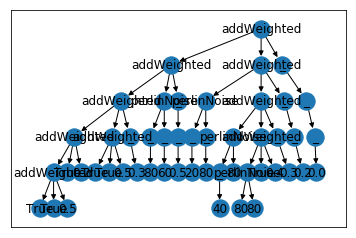

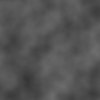

In [0]:
expr = toolbox.individual()
tree = gp.PrimitiveTree(expr)
f = gp.compile(tree, pset)
print(expr)
plotTree(expr)

image = np.zeros((100, 100))
a = f
cv2_imshow(a)

In [0]:
random.seed(10)
pop = toolbox.population(n=20)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(pop, toolbox, 0.5, 0.2, 40, stats, halloffame=hof)

gen	nevals	avg        	std        	min        	max        
0  	20    	-0.00770859	0.000652554	-0.00975414	-0.00670899
1  	16    	-0.00719765	0.000405116	-0.00801487	-0.00654402
2  	8     	-0.00676415	0.00043487 	-0.00751641	-0.00525998
3  	9     	-0.0065087 	0.000447649	-0.00701417	-0.00525998
4  	14    	-0.00621882	0.00053298 	-0.00688123	-0.00525998
5  	9     	-0.0057418 	0.000467332	-0.00651828	-0.00524547
6  	11    	-0.00540254	0.000601618	-0.00632145	-0.00384488
7  	12    	-0.00496635	0.000651388	-0.00622964	-0.00384488
8  	12    	-0.00457955	0.000838856	-0.00631648	-0.00384488
9  	12    	-0.00425835	0.000607567	-0.00544257	-0.00384488
10 	15    	-0.00399726	0.000480093	-0.00583246	-0.00384488
11 	14    	-0.00392314	0.000341121	-0.00541005	-0.00384488
12 	15    	-0.00384488	8.67362e-19	-0.00384488	-0.00384488
13 	13    	-0.00404732	0.000882243	-0.00789293	-0.00384488
14 	15    	-0.00403711	0.000837893	-0.0076894 	-0.00384488
15 	16    	-0.00400259	0.000473317	-0.00546326	-0.003844

([[<deap.gp.Primitive at 0x7f7ae4abeb38>,
 [{'avg': -0.00770858617327642,
   'gen': 0,
   'max': -0.006708985123800033,
   'min': -0.009754138562971536,
   'nevals': 20,
   'std': 0.0006525541246158176},
  {'avg': -0.007197651830129437,
   'gen': 1,
   'max': -0.006544016632027046,
   'min': -0.008014869944805422,
   'nevals': 16,
   'std': 0.0004051158274430274},
  {'avg': -0.0067641483671810314,
   'gen': 2,
   'max': -0.00525998267146452,
   'min': -0.007516409781081899,
   'nevals': 8,
   'std': 0.0004348698492199097},
  {'avg': -0.006508701326137146,
   'gen': 3,
   'max': -0.00525998267146452,
   'min': -0.007014174884172647,
   'nevals': 9,
   'std': 0.00044764932917198556},
  {'avg': -0.006218821356412452,
   'gen': 4,
   'max': -0.00525998267146452,
   'min': -0.006881226630609644,
   'nevals': 14,
   'std': 0.0005329798425207509},
  {'avg': -0.00574179663093427,
   'gen': 5,
   'max': -0.005245469707140962,
   'min': -0.006518277067988453,
   'nevals': 9,
   'std': 0.00046733